# Yearbook of International Organizations Analysis

This notebook analyzes the dataset scraped from the Yearbook of International Organizations (YBIO).

**Dataset:** `data/organizations_final.csv`

**Author:** Diwas Puri (diwas.puri@duke.edu), Duke University


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Load data
try:
    df = pd.read_csv('../data/organizations_clean.csv')
    print("Successfully loaded data from ../data/organizations_clean.csv")
except FileNotFoundError:
    # Fallback for running from root
    try:
        df = pd.read_csv('data/organizations_clean.csv')
        print("Successfully loaded data from data/organizations_clean.csv")
    except FileNotFoundError:
        print("Error: Could not find dataset!")

# Display basic info
if 'df' in locals():
    print(f"Total Organizations: {len(df):,}")
    print(f"Columns: {list(df.columns)}")
    display(df.head())

Successfully loaded data from ../data/organizations_clean.csv
Total Organizations: 78,865
Columns: ['Name', 'Acronym', 'Founded', 'City', 'Country', 'Type I', 'Type II', 'UID']


,Name,Acronym,Founded,City,Country,Type I,Type II,UID
0,Federation of International Dance Festivals,FIDAF,2012.0,Chungnam,Korea Rep,B,NaN,XJ9650
1,Federation of International Geo-Engineering So...,FedIGS,2007.0,NaN,NaN,B,y,AA0037
2,FIDI Global Alliance,NaN,1950.0,Zaventem,Belgium,B,NaN,XB0947
3,Food and Agriculture Organization of the Unite...,FAO,1945.0,Rome,Italy,B,g,XB0971
4,Gender and Water Alliance,GWA,2000.0,Dieren,Netherlands,B,NaN,XM0973


## 1. Data Cleaning & Preprocessing

In [17]:
# Missing counts and percentages
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct.round(2)
}).sort_values('missing_pct', ascending=False)

print("Missing Values per Column")
print(missing_summary)

# Top 10 columns with most missing values
print("\nTop 10 columns by missing percent")
print(missing_summary.head(10))


Missing Values per Column
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00

Top 10 columns by missing percent
         missing_count  missing_pct
City             31526        39.97
Country          31520        39.97
Acronym          29848        37.85
Type II          26978        34.21
Founded          23718        30.07
Name                 0         0.00
Type I               0         0.00
UID                  0         0.00


## 2. Geographic Analysis
Where are these organizations headquartered?

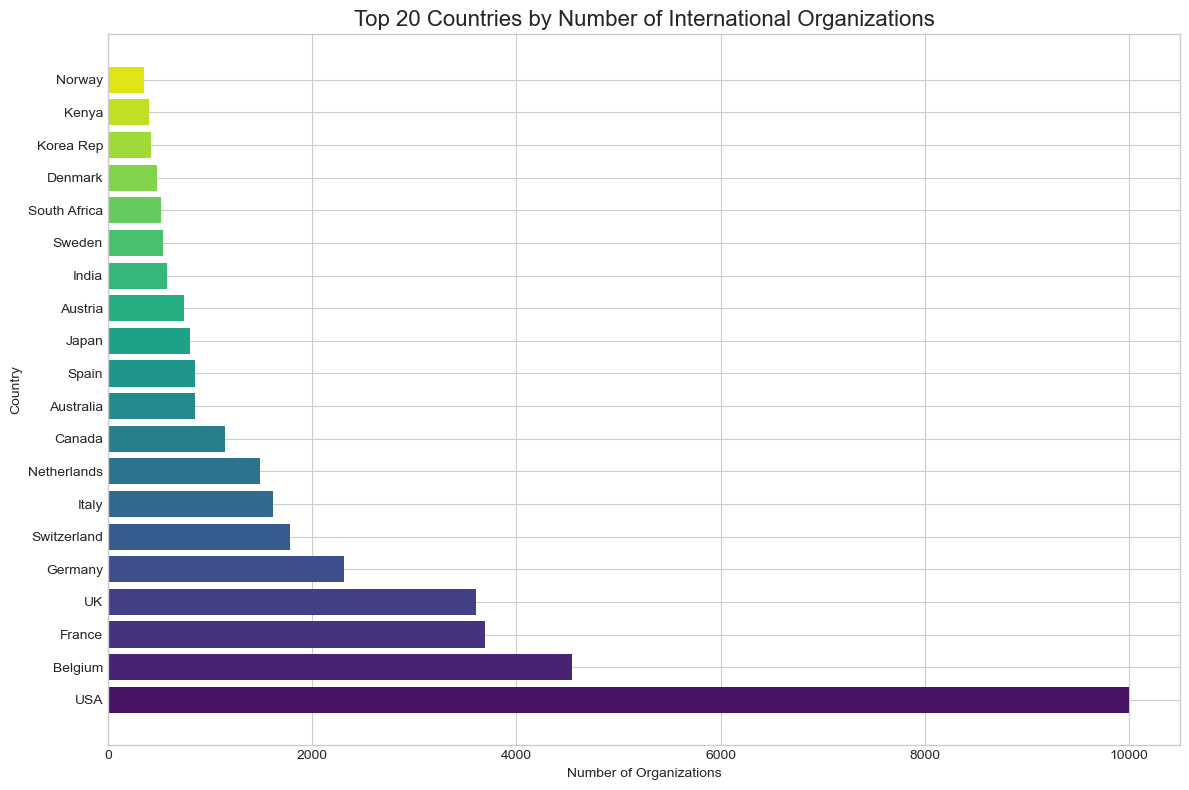

In [18]:
top_countries = df['Country'].value_counts().head(20)

colors = sns.color_palette('viridis', n_colors=len(top_countries))

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_countries.index, top_countries.values, color=colors)
ax.set_title('Top 20 Countries by Number of International Organizations', fontsize=16)
ax.set_xlabel('Number of Organizations')
ax.set_ylabel('Country')
plt.tight_layout()
plt.show()

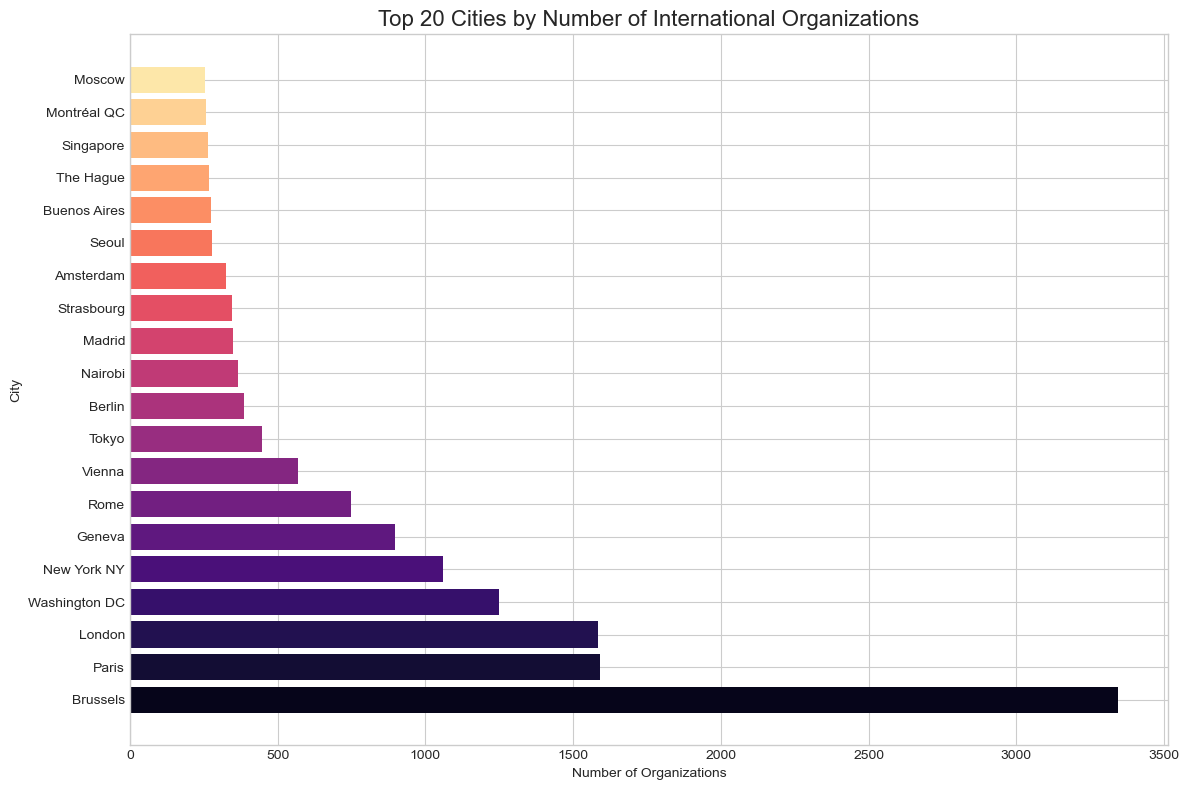

In [19]:
top_cities = df['City'].value_counts().head(20)
colors = sns.color_palette('magma', n_colors=len(top_cities))

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(top_cities.index, top_cities.values, color=colors)
ax.set_title('Top 20 Cities by Number of International Organizations', fontsize=16)
ax.set_xlabel('Number of Organizations')
ax.set_ylabel('City')
plt.tight_layout()
plt.show()


## 3. Temporal Analysis
When were these organizations established?

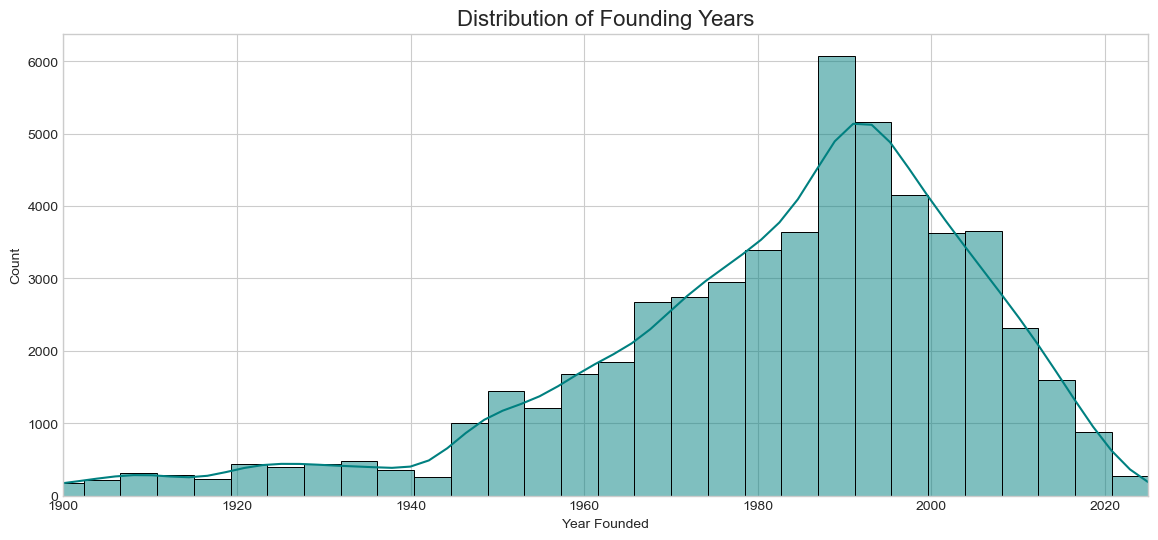

In [20]:

# Ensure valid_years_df exists
if 'valid_years_df' not in locals():
    if 'Founded_Year' not in df.columns:
        df['Founded_Year'] = pd.to_numeric(df['Founded'], errors='coerce')
    valid_years_df = df[(df['Founded_Year'] > 1600) & (df['Founded_Year'] <= 2025)]

plt.figure(figsize=(14, 6))
sns.histplot(data=valid_years_df, x='Founded_Year', bins=100, kde=True, color='teal')
plt.title('Distribution of Founding Years', fontsize=16)
plt.xlabel('Year Founded')
plt.ylabel('Count')
plt.xlim(1900, 2025)
plt.show()

### Understanding YBIO Classification

The Yearbook of International Organizations uses a two-tier classification system:

**Type I (Primary Category)**
- **A**: Federations of international organizations
- **B**: Universal membership organizations
- **C**: Intercontinental membership organizations
- **D**: Regionally defined membership organizations
- **E**: Organizations emanating from places, persons, or other bodies
- **F**: Organizations having a special form
- **G**: Recently reported or proposed organizations
- **H**: Dissolved or apparently inactive organizations
- **U**: Unconfirmed organizations

**Type II (Secondary Category)**
- **c**: International conferences
- **d**: Dissolved organizations
- **e**: National organizations
- **f**: Foundations
- **g**: Intergovernmental organizations
- **j**: Autonomous conference series
- **x**: Commercial or for-profit organizations
- **y**: International non-profit organizations

These classifications help researchers understand the scope, structure, and status of each organization.

## 4. Organization Types
Analyzing Type I and Type II classifications.

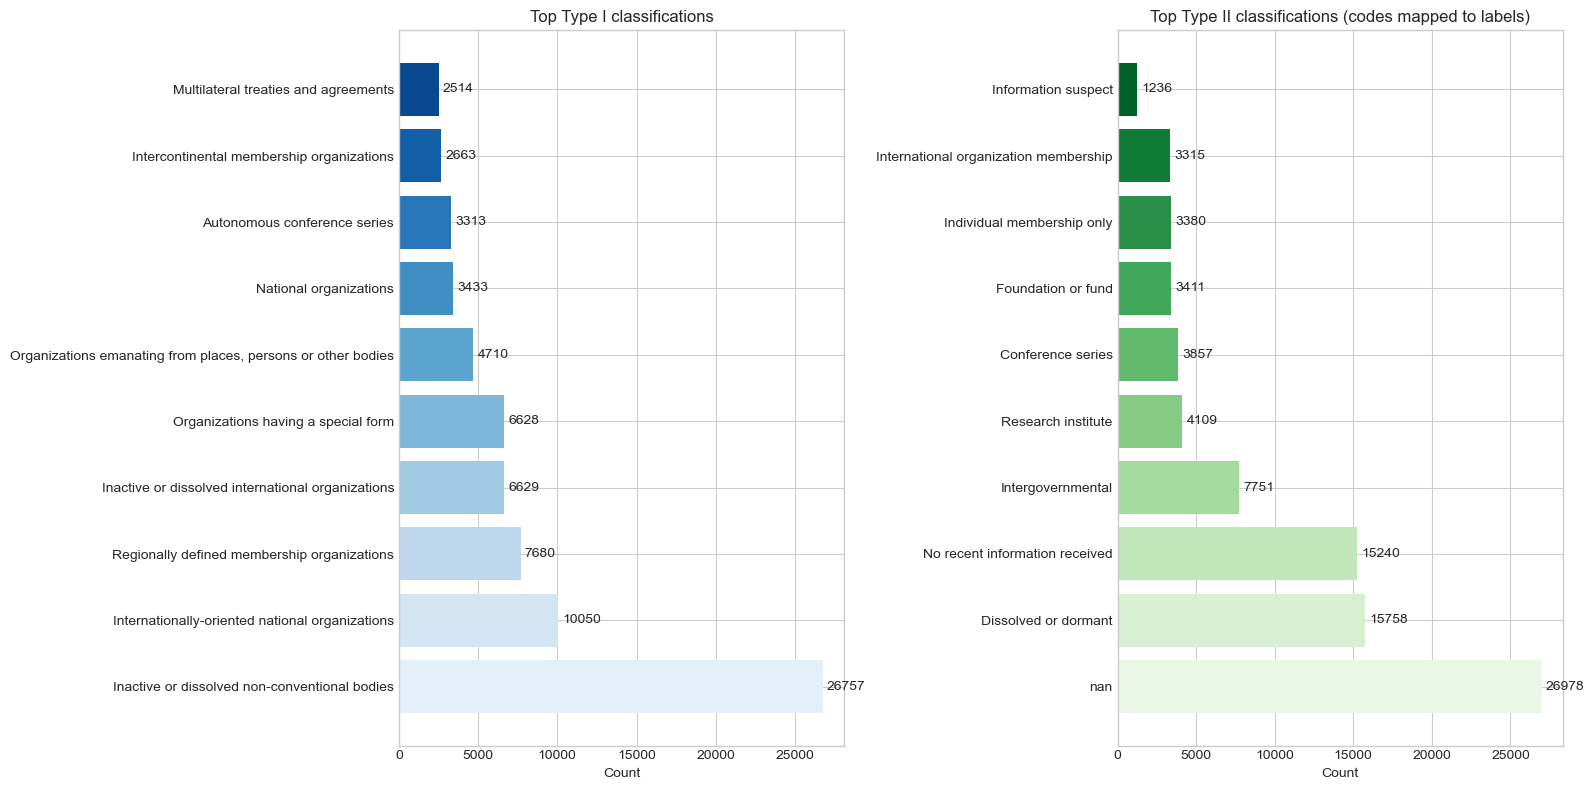

In [21]:


# --- Mappings ---
TYPE_I = {
    "A": "Federations of international organizations",
    "B": "Universal membership organizations",
    "C": "Intercontinental membership organizations",
    "D": "Regionally defined membership organizations",
    "E": "Organizations emanating from places, persons or other bodies",
    "F": "Organizations having a special form",
    "G": "Internationally-oriented national organizations",
    "H": "Inactive or dissolved international organizations",
    "J": "Recently reported or proposed international organizations",
    "K": "Subsidiary and internal bodies",
    "N": "National organizations",
    "R": "Religious orders, fraternities and secular institutes",
    "S": "Autonomous conference series",
    "T": "Multilateral treaties and agreements",
    "U": "Inactive or dissolved non-conventional bodies"
}

TYPE_II = {
    "b": "Bilateral intergovernmental organization",
    "c": "Conference series",
    "d": "Dissolved or dormant",
    "e": "Commercial enterprise",
    "f": "Foundation or fund",
    "g": "Intergovernmental",
    "j": "Research institute",
    "n": "Has become national",
    "p": "Proposed body",
    "s": "Information suspect",
    "v": "Individual membership only",
    "x": "No recent information received",
    "y": "International organization membership"
}

# --- Helper to parse Type II robustly ---
def split_type2_codes(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    for sep in [",", ";", "/", "|"]:
        s = s.replace(sep, " ")
    parts = [p.strip() for p in s.split() if p.strip()]
    codes = []
    for p in parts:
        if len(p) > 1 and all(ch in TYPE_II for ch in p):
            codes.extend(list(p))
        else:
            codes.append(p)
    return codes

# --- Map and prepare counts (assumes `df` exists) ---
df_plot = df.copy()
df_plot["Type I Label"] = df_plot["Type I"].astype(str).str.strip().map(TYPE_I).fillna("Unknown Type I")
df_plot["Type II Codes"] = df_plot["Type II"].apply(split_type2_codes)

# Count Type I
type1_counts = df_plot["Type I Label"].value_counts().head(10)

# Flatten Type II codes and map to labels, then count
type2_exploded = df_plot.explode("Type II Codes")
type2_exploded["Type II Label"] = type2_exploded["Type II Codes"].map(TYPE_II).fillna(type2_exploded["Type II Codes"].astype(str))
type2_counts = type2_exploded["Type II Label"].value_counts().head(10)

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Type I (horizontal bar)
colors1 = sns.color_palette("Blues_r", n_colors=len(type1_counts))
axes[0].barh(type1_counts.index[::-1], type1_counts.values[::-1], color=colors1)
axes[0].set_title("Top Type I classifications")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("")
axes[0].invert_yaxis()

# Annotate Type I bars
for i, v in enumerate(type1_counts.values[::-1]):
    axes[0].text(v + max(type1_counts.values) * 0.01, i, str(v), va="center")

# Type II (horizontal bar)
colors2 = sns.color_palette("Greens_r", n_colors=len(type2_counts))
axes[1].barh(type2_counts.index[::-1], type2_counts.values[::-1], color=colors2)
axes[1].set_title("Top Type II classifications (codes mapped to labels)")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].invert_yaxis()

# Annotate Type II bars
for i, v in enumerate(type2_counts.values[::-1]):
    axes[1].text(v + max(type2_counts.values) * 0.01, i, str(v), va="center")

plt.tight_layout()
plt.show()


## 5. Word Cloud of Names

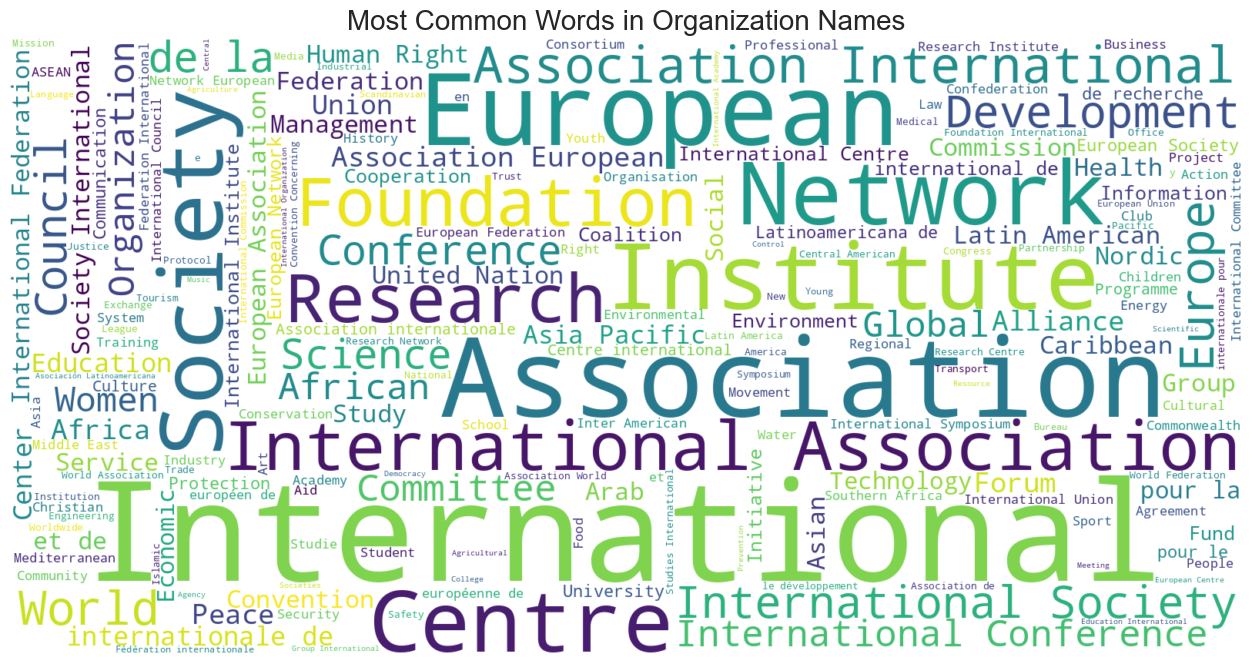

In [22]:
from wordcloud import WordCloud

# Combine all names
text = ' '.join(df['Name'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='viridis').generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Organization Names', fontsize=20)
plt.show()

## 6. Geographic Distribution - Interactive World Map

Visualizing the global distribution of international organizations.

In [ ]:
# Update COUNTRY_COORDS with comprehensive mapping (200+ countries)
COUNTRY_COORDS.update({
    # Missing countries from the dataset
    'Türkiye': (38.9637, 35.2433), 'United Arab Emirates': (23.4241, 53.8478),
    'Czechia': (49.8175, 15.4730), 'Hong Kong': (22.3193, 114.1694),
    'Taiwan': (23.6978, 120.9605), 'Trinidad-Tobago': (10.6918, -61.2225),
    'Côte d\'Ivoire': (7.5400, -5.5471), 'Tanzania UR': (-6.3690, 34.8888),
    'Burkina Faso': (12.2383, -1.5616), 'Fiji': (-17.7134, 178.0650),
    'Togo': (8.6195, 0.8248), 'Barbados': (13.1939, -59.5432),
    'Iran Islamic Rep': (32.4279, 53.6880), 'Benin': (9.3077, 2.3158),
    'Estonia': (58.5953, 25.0136), 'Vatican': (41.9029, 12.4534),
    'Congo DR': (-4.0383, 21.7587), 'Latvia': (56.8796, 24.6032),
    'Puerto Rico': (18.2208, -66.5901), 'Nicaragua': (12.8654, -85.2072),
    'Papua New Guinea': (-6.3150, 143.9555), 'Lithuania': (55.1694, 23.8813),
    'Honduras': (15.2000, -86.2419), 'Albania': (41.1533, 20.1683),
    'Mauritius': (-20.3484, 57.5522), 'Haiti': (18.9712, -72.2852),
    'Malawi': (-13.2543, 34.3015), 'Madagascar': (-18.7669, 46.8691),
    'Mali': (17.5707, -3.9962), 'Niger': (17.6078, 8.0817),
    'Chad': (15.4542, 18.7322), 'Rwanda': (-1.9403, 29.8739),
    'Burundi': (-3.3731, 29.9189), 'Somalia': (5.1521, 46.1996),
    'South Sudan': (6.8770, 31.3070), 'Sudan': (12.8628, 30.2176),
    'Eritrea': (15.1794, 39.7823), 'Djibouti': (11.8251, 42.5903),
    'Gabon': (-0.8037, 11.6094), 'Congo': (-0.2280, 15.8277),
    'Central African Republic': (6.6111, 20.9394), 'Equatorial Guinea': (1.6508, 10.2679),
    'Sao Tome and Principe': (0.1864, 6.6131), 'Mauritania': (21.0079, -10.9408),
    'Gambia': (13.4432, -15.3101), 'Guinea-Bissau': (11.8037, -15.1804),
    'Guinea': (9.9456, -9.6966), 'Sierra Leone': (8.4606, -11.7799),
    'Liberia': (6.4281, -9.4295), 'Cape Verde': (16.5388, -23.0418),
    'Comoros': (-11.6455, 43.3333), 'Seychelles': (-4.6796, 55.4920),
    'Lesotho': (-29.6100, 28.2336), 'Eswatini': (-26.5225, 31.4659),
    'Bhutan': (27.5142, 90.4336), 'Maldives': (3.2028, 73.2207),
    'Brunei': (4.5353, 114.7277), 'Timor-Leste': (-8.8742, 125.7275),
    'Korea DPR': (40.3399, 127.5101), 'Turkmenistan': (38.9697, 59.5563),
    'Tajikistan': (38.8610, 71.2761), 'Kyrgyzstan': (41.2044, 74.7661),
    'Armenia': (40.0691, 45.0382), 'Azerbaijan': (40.1431, 47.5769),
    'Georgia': (42.3154, 43.3569), 'Moldova': (47.4116, 28.3699),
    'North Macedonia': (41.6086, 21.7453), 'Bosnia and Herzegovina': (43.9159, 17.6791),
    'Montenegro': (42.7087, 19.3744), 'Kosovo': (42.6026, 20.9030),
    'San Marino': (43.9424, 12.4578), 'Andorra': (42.5063, 1.5218),
    'Palestine': (31.9522, 35.2332), 'Macao': (22.1987, 113.5439),
    'French Polynesia': (-17.6797, -149.4068), 'New Caledonia': (-20.9043, 165.6180),
    'Guam': (13.4443, 144.7937), 'Virgin Islands': (18.3358, -64.8963),
    'Martinique': (14.6415, -61.0242), 'Guadeloupe': (16.2650, -61.5510),
    'Réunion': (-21.1151, 55.5364), 'Mayotte': (-12.8275, 45.1662),
    'Aruba': (12.5211, -69.9683), 'Curaçao': (12.1696, -68.9900),
    'Sint Maarten': (18.0425, -63.0548), 'Cayman Islands': (19.3133, -81.2546),
    'Bermuda': (32.3078, -64.7505), 'Greenland': (71.7069, -42.6043),
    'Faroe Islands': (61.8926, -6.9118), 'Gibraltar': (36.1408, -5.3536),
    'Isle of Man': (54.2361, -4.5481), 'Jersey': (49.2144, -2.1312),
    'Dominican Republic': (18.7357, -70.1627), 'El Salvador': (13.7942, -88.8965),
    'Belize': (17.1899, -88.4976), 'Guyana': (4.8604, -58.9302),
    'Suriname': (3.9193, -56.0278), 'Falkland Islands': (-51.7963, -59.5236),
    'Samoa': (-13.7590, -172.1046), 'Tonga': (-21.1789, -175.1982),
    'Kiribati': (-3.3704, -168.7340), 'Tuvalu': (-7.1095, 177.6493),
    'Nauru': (-0.5228, 166.9315), 'Palau': (7.5150, 134.5825),
    'Micronesia': (7.4256, 150.5508), 'Marshall Islands': (7.1315, 171.1845),
    'Vanuatu': (-15.3767, 166.9592), 'Solomon Islands': (-9.6457, 160.1562),
})

# Re-map coordinates with expanded dictionary
df['latitude'] = df['Country'].map(lambda x: COUNTRY_COORDS.get(x, (None, None))[0] if pd.notna(x) else None)
df['longitude'] = df['Country'].map(lambda x: COUNTRY_COORDS.get(x, (None, None))[1] if pd.notna(x) else None)

# Update mapped dataframe
df_mapped = df.dropna(subset=['latitude', 'longitude']).copy()

print(f"✓ Updated coordinate mapping")
print(f"Organizations with coordinates: {len(df_mapped)} ({len(df_mapped)/len(df)*100:.1f}%)")
print(f"Countries now mapped: {df_mapped['Country'].nunique()}")

In [23]:
# Aggregate organizations by country
country_stats = df_mapped.groupby('Country').agg({
    'latitude': 'first',
    'longitude': 'first',
    'Name': 'count'
}).rename(columns={'Name': 'count'}).reset_index()

print(f"Countries with organizations: {len(country_stats)}")
print(f"Total mapped organizations: {country_stats['count'].sum()}")
print(f"\nTop 10 countries by organization count:")
print(country_stats.nlargest(10, 'count')[['Country', 'count']].to_string(index=False))

Countries with organizations: 103
Total mapped organizations: 44996

Top 10 countries by organization count:
    Country  count
        USA   9997
    Belgium   4543
     France   3689
         UK   3606
    Germany   2314
Switzerland   1778
      Italy   1614
Netherlands   1491
     Canada   1142
  Australia    854


In [26]:
# Check which countries are missing from the coordinate mapping
all_countries = df['Country'].dropna().unique()
mapped_countries = df_mapped['Country'].unique()
missing_countries = set(all_countries) - set(mapped_countries)

print(f"Total unique countries in dataset: {len(all_countries)}")
print(f"Countries with coordinates: {len(mapped_countries)}")
print(f"Countries missing coordinates: {len(missing_countries)}")

if len(missing_countries) > 0:
    # Count organizations in missing countries
    missing_df = df[df['Country'].isin(missing_countries)]
    missing_counts = missing_df['Country'].value_counts().head(20)
    print(f"\nTop 20 countries without coordinates (with org counts):")
    print(missing_counts.to_string())

Total unique countries in dataset: 216
Countries with coordinates: 103
Countries missing coordinates: 113

Top 20 countries without coordinates (with org counts):
Country
Hong Kong               196
Czechia                 134
United Arab Emirates    111
Taiwan                  105
Türkiye                  99
Trinidad-Tobago          92
Côte d'Ivoire            82
Tanzania UR              80
Burkina Faso             69
Fiji                     65
Togo                     58
Barbados                 56
Iran Islamic Rep         53
Benin                    52
Estonia                  52
Vatican                  49
Congo DR                 46
Latvia                   43
Puerto Rico              41
Nicaragua                36


In [24]:
# Create interactive map with country-level aggregation
m = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap', control_scale=True)

# Add circle markers sized by number of organizations
for idx, row in country_stats.iterrows():
    # Get sample organizations from this country
    country_orgs = df_mapped[df_mapped['Country'] == row['Country']]['Name'].head(10).tolist()
    sample_list = '<br>• '.join(country_orgs[:5])
    more_text = f"<br>...and {row['count']-5} more" if row['count'] > 5 else ""
    
    popup_html = f"""
    <div style="width: 350px;">
        <h3>{row['Country']}</h3>
        <b>Total Organizations:</b> {row['count']}<br><br>
        <b>Sample Organizations:</b><br>
        • {sample_list}{more_text}
    </div>
    """
    
    # Circle size based on number of orgs (logarithmic scale)
    radius = max(5, min(30, 5 + np.log10(row['count'] + 1) * 8))
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup=folium.Popup(popup_html, max_width=350),
        tooltip=f"{row['Country']}: {row['count']} organizations",
        color='darkblue',
        fill=True,
        fillColor='steelblue',
        fillOpacity=0.6,
        weight=2
    ).add_to(m)

m.save('../data/organizations_map.html')
print("✓ Interactive map saved to: data/organizations_map.html")
m

✓ Interactive map saved to: data/organizations_map.html


In [25]:
# Create heatmap of organization density
m_heat = folium.Map(location=[20, 0], zoom_start=2, tiles='OpenStreetMap')

# Prepare heat data with weights (one entry per country with weight = org count)
heat_data = [[row['latitude'], row['longitude'], row['count']] 
             for idx, row in country_stats.iterrows()]

HeatMap(
    heat_data,
    name='Organization Density',
    min_opacity=0.3,
    max_zoom=13,
    radius=25,
    blur=30,
    gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
).add_to(m_heat)

m_heat.save('../data/organizations_heatmap.html')
print("✓ Heatmap saved to: data/organizations_heatmap.html")
m_heat

✓ Heatmap saved to: data/organizations_heatmap.html
